# Recommender Systems

# Библиотеки

In [1]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

from sklearn.neighbors import NearestNeighbors



# Данные

В качестве данных будем использовать датасет от MTS.AI: [kion-data](https://arxiv.org/pdf/2209.00325.pdf).  
Это информация о просмотрах пользователей различных фильмов и сериалов с названиями, описаниями и прочими фичами. 
**Обратите внимание, что вы можете парсить интернет, для получения дополнительных фичей! Только не забудьте описать, какие фичи вы взяли и где вы их достали!**   
Мы заранее поделили выборки на тренировочную и тестовую части, поэтому **просим** вас придерживаться следующих правил: с тренировочными данными разрешается делать **всё что угодно**, тестовую же часть **запрещается изменять**!  

Датасет представляет из себя 4 файла: тренировочную часть (`train_data.csv`), тестовую часть(`test_data.csv`), описание пользователей(`users.csv`) и описание айтемов(`items_.csv`). 

In [2]:
data_folder = "kion_data/"

users_df = pd.read_csv(data_folder + "users.csv")
items_df = pd.read_csv(data_folder + "items.csv")
train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["last_watch_dt"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"ground_truth": list}).reset_index()


# Пользователи

In [3]:
users_df.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,721985,age_45_54,income_20_40,Ж,0
3,704055,age_35_44,income_60_90,Ж,0
4,846063,age_35_44,income_40_60,Ж,1


## Какие есть признаки?

1. `user_id` – индентификатор пользователя, уникален для каждого
2. `age` – категориальный признак, показывающий возрастную группу пользователя
3. `income` – категориальный признак, показывающий зарплатную группу пользователя
4. `sex` – пол пользователя
5. `kids_flg` – наличие детей у пользователя


# Айтемы

In [4]:
items_df.head(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."


## Какие есть признаки?

1. `item_id` – индентификатор айтема, уникален для каждого
2. `content_type` – категориальный признак, тип айтема (фильм, сериал и т.д.)
3. `title` – Название на русском языке
4. `title_orig` – Название на языке оригинала
5. `release_year` – год выхода 
6. `genres` – список жанров (представлен строкой)
7. `countries` – страна издания
8. `for_kids` – предназначен для детей
9. `age_rating` – возрастной рейтинг картины
10. `studios` – студия, выпустившая картину
11. `directors` – режиссер(ы)
12. `actors` – актёры
13. `description` – описание (на русском)
14. `keywords` – ключевые слова, описывающие картину


# Просмотры пользователей

### Тренировачные данные

In [5]:
print(f"Число тренировачных интеракций: {len(train_part):,}")
train_part.head()

Число тренировачных интеракций: 1,224,560


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0


### Тестовые данные

In [6]:
print(f"Число тестовых пользователей: {len(test_part):,}")
test_part.head()

Число тестовых пользователей: 18,693


,user_id,ground_truth
0,30,"[8584, 3031, 15363]"
1,144,"[3800, 11987, 10942]"
2,241,"[14841, 6162, 5808, 15266]"
3,259,"[16509, 10509, 4491, 5434, 4471, 10772, 817]"
4,475,"[6214, 3734, 6686]"


### Обратите внимание, что формат данных тестовой и тренировочной частей отличается. 
#### Это сделано для того, чтобы вы могли использовать дополнительную информацию в своих моделях, например такую как время просмотра (`total_dur`), процент просмотра(`watched_pct`), а так же дату последнего просмотра (`last_watch_dt`)
#### При этом на тренировачных данных такой информации нет, так как мы не можем смотреть в будущее.     

#### Тестовые данные также приведены в удобный для подсчета метрик вид.

# Метрики

#### Кратко расскажем про метрики, которые мы будем использовать для измерения качества наших моделей.  

Мы будем смотреть всего на две метрики: **ndcg** и **recall**.  
Все метрики измеряются до какой-то позиции, у нас это будет **10**. То есть мы отдаем 10 самых подходящих пользователю айтемов по мнению модели и говорим, что это и есть наши рекомендации, качество которых мы хотим оценить.  

**ndcg** показывает, как модель справляется с задачей ранжирования, то есть ставит просмотренные айтемы выше непросмотренных
**recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

*Для обоих метрик лучше та, которая как можно ближе к **1.0***

Не бойтесь, если вам сейчас что-то непонятно, подробнее про метрики мы расскажем на смене или можете почитать в интернете:)

#### Ниже представлен код реализации, пожалуйста, не меняйте его!

In [7]:
# ACHTUNG! DO NOT TOUCH 

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

#### Класс, от которого стоит наследовать все ваши модели, чтобы эксперименты было проще проводить

In [8]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из item_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

# Начнем с предобработки данных

In [9]:
users_df.isnull().sum()

user_id        0
age         3582
income      3349
sex         4061
kids_flg       0
dtype: int64

In [10]:
users_df.loc[users_df.age.isna(), 'age'] = 'age_unknown'
users_df.loc[users_df.income.isna(), 'income'] = 'income_unknown'
users_df.loc[users_df.sex.isna(), 'sex'] = 'sex_unknown'

users_df.isnull().sum()

user_id     0
age         0
income      0
sex         0
kids_flg    0
dtype: int64

Пропуски готовы, теперь приведем типы данных

In [11]:
users_df['sex'] = users_df['sex'].astype('category')
users_df['age'] = users_df['age'].astype('category')
users_df['income'] = users_df['income'].astype('category')
users_df['kids_flg'] = users_df['kids_flg'].astype('bool')

users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366088 entries, 0 to 366087
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   user_id   366088 non-null  int64   
 1   age       366088 non-null  category
 2   income    366088 non-null  category
 3   sex       366088 non-null  category
 4   kids_flg  366088 non-null  bool    
dtypes: bool(1), category(3), int64(1)
memory usage: 4.2 MB


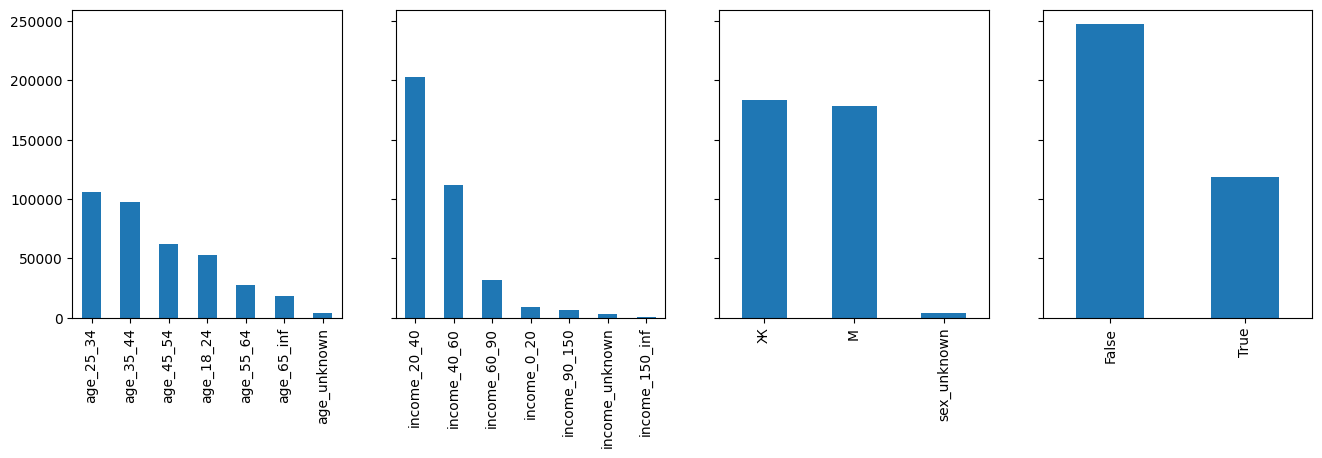

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16,4))

# кол-во пользователей по возрастным группам
users_df.age.value_counts().plot.bar(ax=axes[0])

# кол-во пользователей по уровню дохода
users_df.income.value_counts().plot.bar(ax=axes[1])

# кол-во пользователей по полу
users_df.sex.value_counts().plot.bar(ax=axes[2])

# кол-во пользователей без детей и с детьми
users_df.kids_flg.value_counts().plot.bar(ax=axes[3])

plt.show()

Небольшие выводы из графиков
- Основные клиенты сервиса - люди в возврастном промежутке 25-34 и 35-44 года
- Так же большая часть клиентов имеет доход от 20 до 40 т.р.
- Распределение по полу +- 50 на 50
- Бездетных пользователей примерно в 2 раза больше чем пользователей с детьми

In [13]:
# Небольшая проверка на дубликаты
users_df.duplicated(subset=['user_id']).sum()

0

Добавим новые категориальные фичи: возраст_пол, доход_пол, возраст_доход

In [14]:
users_df['age_sex'] = (users_df['age'].astype(str) + '_' + users_df['sex'].astype(str)).astype('category')
users_df['income_sex'] = (users_df['income'].astype(str) + '_' + users_df['sex'].astype(str)).astype('category')
users_df['age_income'] = (users_df['age'].astype(str) + '_' + users_df['income'].astype(str)).astype('category')

Добавим общее количество просмотров для каждого пользователя и средний процент просмотра

In [15]:
grouped_data = train_part.groupby(['user_id']).agg({'item_id':'count', 'watched_pct':'mean'})
grouped_data = grouped_data.rename(columns={'item_id': 'nwatched', 'watched_pct': 'mean_watched_pct'})
users_df = users_df.merge(grouped_data, how='left', on='user_id')
users_df = users_df.fillna(0)

In [16]:
users_df

,user_id,age,income,sex,kids_flg,age_sex,income_sex,age_income,nwatched,mean_watched_pct
0,973171,age_25_34,income_60_90,М,True,age_25_34_М,income_60_90_М,age_25_34_income_60_90,3,68.333333
1,962099,age_18_24,income_20_40,М,False,age_18_24_М,income_20_40_М,age_18_24_income_20_40,6,49.500000
2,721985,age_45_54,income_20_40,Ж,False,age_45_54_Ж,income_20_40_Ж,age_45_54_income_20_40,6,53.000000
3,704055,age_35_44,income_60_90,Ж,False,age_35_44_Ж,income_60_90_Ж,age_35_44_income_60_90,3,5.333333
4,846063,age_35_44,income_40_60,Ж,True,age_35_44_Ж,income_40_60_Ж,age_35_44_income_40_60,1,50.000000
...,...,...,...,...,...,...,...,...,...,...
366083,848247,age_18_24,income_20_40,Ж,False,age_18_24_Ж,income_20_40_Ж,age_18_24_income_20_40,2,3.500000
366084,950528,age_35_44,income_20_40,М,True,age_35_44_М,income_20_40_М,age_35_44_income_20_40,1,13.000000
366085,1021167,age_65_inf,income_20_40,Ж,False,age_65_inf_Ж,income_20_40_Ж,age_65_inf_income_20_40,1,0.000000
366086,312839,age_65_inf,income_60_90,Ж,False,age_65_inf_Ж,income_60_90_Ж,age_65_inf_income_60_90,1,2.000000


In [17]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366088 entries, 0 to 366087
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   user_id           366088 non-null  int64   
 1   age               366088 non-null  category
 2   income            366088 non-null  category
 3   sex               366088 non-null  category
 4   kids_flg          366088 non-null  bool    
 5   age_sex           366088 non-null  category
 6   income_sex        366088 non-null  category
 7   age_income        366088 non-null  category
 8   nwatched          366088 non-null  int64   
 9   mean_watched_pct  366088 non-null  float64 
dtypes: bool(1), category(6), float64(1), int64(2)
memory usage: 13.6 MB


# Перейдем к фильмам items

In [18]:
items_df.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,11114,film,Принцесса Лебедь: Пират или принцесса,"The Swan Princess: Princess Tomorrow, Pirate T...",2016.0,"для детей, сказки, полнометражные, зарубежные,...",США,NaN,6.0,Sony Pictures,Ричард Рич,"Брайан Ниссен, Гарднер Джаэс, Грант Дураззо, Д...",Анимационная сказка о непоседливой принцессе Э...,"Принцесса, Лебедь, Пират, или, принцесса, 2016..."


In [19]:
# Беглый осмотр данных
print(items_df.info())
print(items_df.nunique())
print()
print()
print('Missed values')
print(items_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12067 entries, 0 to 12066
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       12067 non-null  int64  
 1   content_type  12067 non-null  object 
 2   title         12067 non-null  object 
 3   title_orig    9144 non-null   object 
 4   release_year  12019 non-null  float64
 5   genres        12067 non-null  object 
 6   countries     12051 non-null  object 
 7   for_kids      528 non-null    float64
 8   age_rating    12066 non-null  float64
 9   studios       749 non-null    object 
 10  directors     11160 non-null  object 
 11  actors        10268 non-null  object 
 12  description   12066 non-null  object 
 13  keywords      11705 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.3+ MB
None
item_id         12067
content_type        2
title           11621
title_orig       8675
release_year      102
genres           2312
cou

**content_type**

<Axes: >

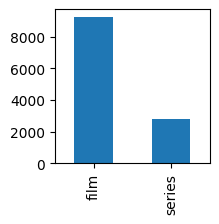

In [20]:
items_df.content_type = items_df.content_type.astype('category')
items_df.content_type.value_counts().plot.bar(figsize=(2,2))

Большая часть контента - фильмы. Пропусков нет

**title title_orig**

В title_orig 2923 пропусков, когда колонка title без пропусков.
Скорее всего это связано с тем, что на платформе довольно много российских фильмов, которые имеют только title (без версии для зарубежного рынка)

In [21]:
items_df.loc[items_df.title_orig.isna(), 'title_orig'] = 'None_title_orig'
items_df.title_orig.isna().sum()

0

In [22]:
# Приведем к нужному типу и переведем весь текст к нижнему регистру
items_df.title = items_df.title.astype('category')
items_df.title_orig = items_df.title_orig.astype('category')
items_df.title = items_df.title.str.lower()

**release_year**

<Axes: >

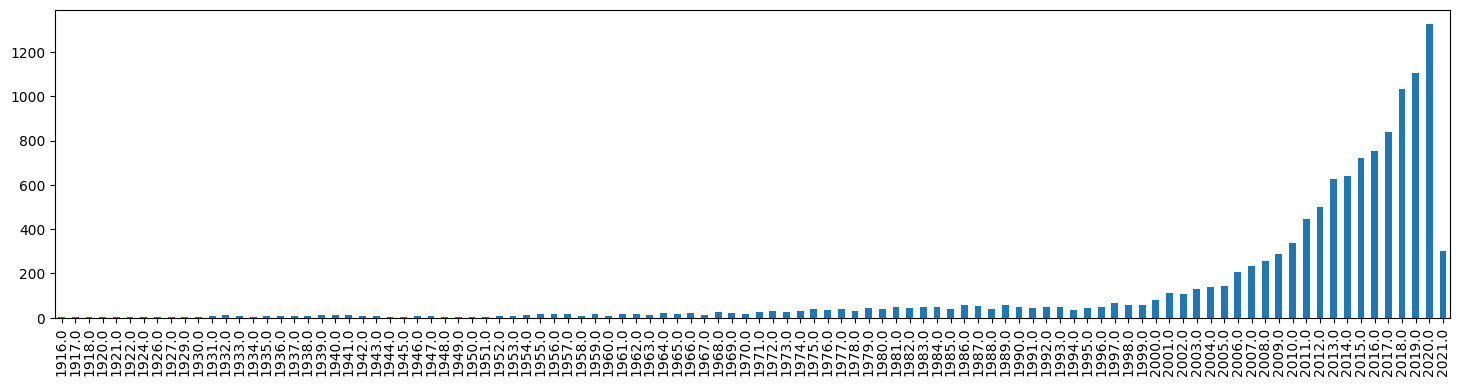

In [23]:
# кол-во контента по годам выпуска
items_df.release_year.value_counts().sort_index().plot.bar(figsize=(18,4))

In [24]:
# В колонке присутствуют 48 пропусков, заполним их
items_df.loc[items_df.release_year.isna(), 'release_year'] = 2020
items_df.release_year = items_df.release_year.astype(int)
items_df.release_year.isna().sum()

0

In [25]:
# Выделим отдельную фичу decade. Она будет отвечать в какое десятилетие выпущен фильм
# Будем брать как расстояние от 2000 года. Наприме 1990 - (-1), 2009 - 0, 2010 - 1, 2020 - 2

def decade(years)-> list:
    decs = []
    for year in years:
        if year == 'release_year_unknown':
            decs.append(-10)
        elif int(year) > 2000:
            decs.append(int(year)%2000//10)
        else:
            decs.append((int(year)-2000)//10)
            
    return decs
            
items_df['decade'] = decade(items_df.release_year)


**genres** 

Пропусков нет

In [26]:
items_df.genres.value_counts()
items_df.genres = items_df.genres.astype('category')

**countries**

<Axes: >

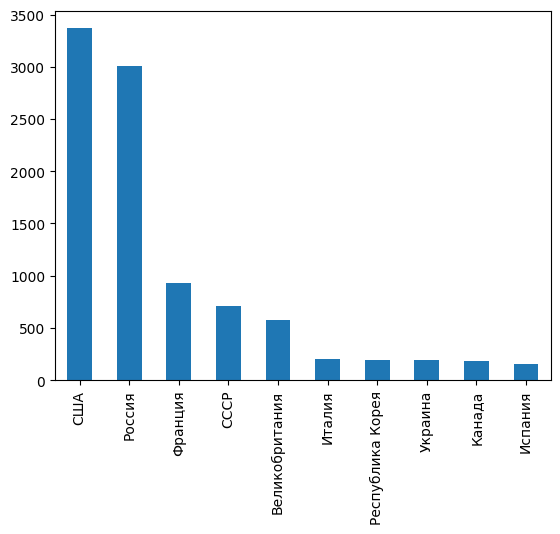

In [27]:
# Топ 10 стран по наличию контента на площадке
items_df.countries.value_counts().head(10).plot.bar()

Самые крупные страны-производители фильмов в данном видеосервисе - это Россия и США.

In [28]:
# Все к нижнему регистру
items_df.countries = items_df.countries.str.lower()

# В данных 16 пропусков
items_df.loc[items_df.countries.isna(), 'countries'] = 'countries_unknown'
items_df.countries = items_df.countries.astype('category')
items_df.countries.isna().sum()

0

**age_rating**

Тут один пропуск на детском мультике. Погуглив находим рейтинг 0+

In [29]:
items_df[items_df.age_rating.isna()]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,decade
9366,14409,series,бибабу,None_title_orig,2017,"русские, сериалы, для детей, хочу всё знать, р...",россия,NaN,NaN,NaN,NaN,NaN,В сказочное подводное царство приглашают мален...,"друзья, магия и волшебство, рыбы, моря и океан...",1


In [30]:
items_df.loc[items_df.age_rating.isna(), 'age_rating'] = 0
items_df.age_rating = items_df.age_rating.astype('category')
items_df.age_rating.isna().sum()

0

In [31]:
# Стоит переделать данный признак в категориальный
items_df.age_rating = items_df.age_rating.astype('category')

**for_kids**

 Тут пропусков заметно больше - 11539. 
 

In [32]:
items_df[['for_kids', 'age_rating']].value_counts()

for_kids  age_rating
0.0       16.0          199
          18.0          128
          12.0           81
1.0       0.0            79
          6.0            26
0.0       6.0            13
          0.0             1
1.0       12.0            1
dtype: int64

In [33]:
items_df.shape

(12067, 15)

In [34]:
# Посмотрим сколько данных сможем закрыть, если будем искать ключевые слова в жанрах
# Ключевые слова подобрал отдельно
items_df[((items_df.genres.str.contains('для детей')) | items_df.genres.str.contains('детские')| 
          items_df.genres.str.contains('kids')) & 
         (items_df.for_kids.isna())].shape

(581, 15)

Довольно спорный признак, тк пропусков намного больше половины. Рискнем и оставим его! Информации мало, но мы видим, что большинство фильмов для детей или 0+ или 6+. Скорее всего наличиче контента 6+ или 0+ помеченным как "не для детей" объясняется разными спортивными курсами и похожими вещами. Но тк такие курсы помечаются как "series", а объектов такого типа меньше фильмов, то сделаем флаг в соответствии с возврастным ограничением.

In [35]:
nan_rows = items_df.loc[items_df['for_kids'].isnull()]
nan_rows['for_kids'] = nan_rows['age_rating'].apply(lambda x: 1 if x <= 12 else 0)
items_df.update(nan_rows)
items_df.for_kids.isna().sum()

/tmp/ipykernel_27190/2850308065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_rows['for_kids'] = nan_rows['age_rating'].apply(lambda x: 1 if x <= 12 else 0)


0

**studios**

Тут тоже пропусков много - 11318

0


<Axes: >

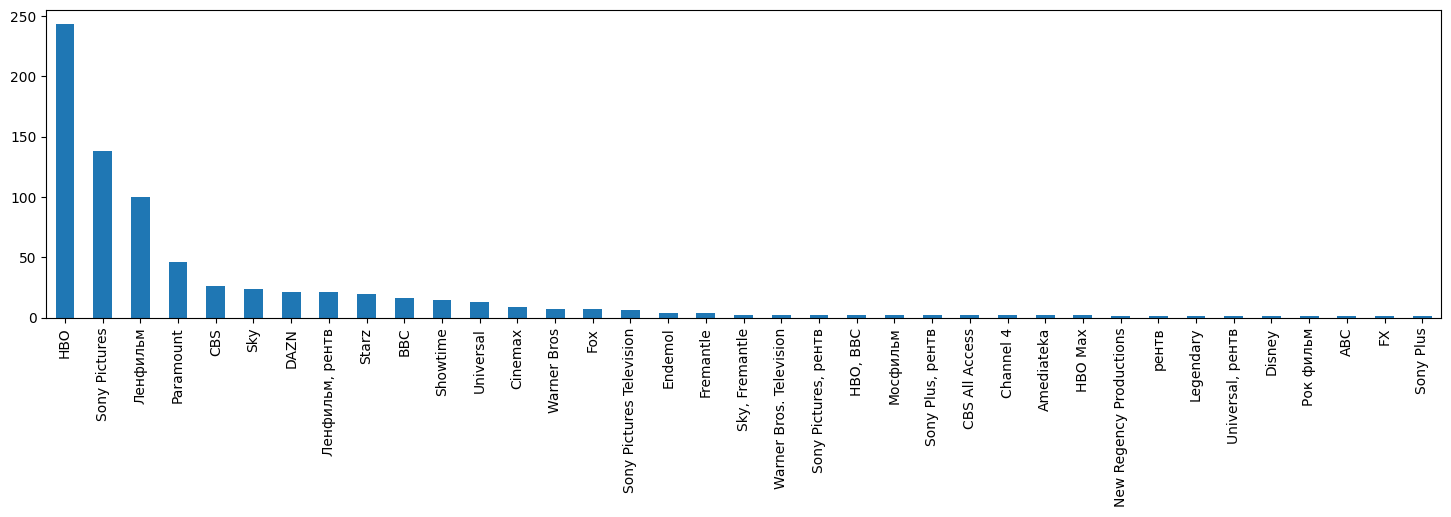

In [36]:
items_df.loc[items_df.studios.isna(), 'studios'] = 'studios_unknown'
print(items_df.studios.isna().sum())
items_df.studios.value_counts()[1:].plot.bar(figsize=(18,4))

In [37]:
# приведем к нижнему регистру
items_df.studios = items_df.studios.str.lower()
items_df.studios = items_df.studios.astype('category')

**directors**

Пропуски - 907

In [38]:
items_df.directors.fillna('directors_unknown', inplace=True)
items_df.directors.isna().sum()

0

In [39]:
# Все к нижнему регистру
items_df.directors = items_df.directors.str.lower()
items_df.directors = items_df.directors.astype('category')

**actors**

Пропуски - 1799

In [40]:
items_df.actors.fillna('actors_unknown', inplace=True)
print(items_df.actors.isna().sum())
items_df.actors = items_df.actors.str.lower()
items_df.actors = items_df.actors.astype('category')

0


**description**

Пропуски - 1 

In [41]:
items_df.description.fillna('None_description', inplace=True)
items_df.description.isna().sum()

0

**keywords**

Пропуски - 362

In [42]:
items_df.keywords.fillna('None_keywords', inplace=True)
items_df.keywords.isna().sum()

0

Фуууух, с фичами items закончили. Удалим дубликаты

In [43]:
items_df[items_df.duplicated(subset=['item_id'],  keep=False)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,decade


In [44]:
items_df[items_df.duplicated(subset=['content_type', 'countries', 'title', 'directors'],  keep=False)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,decade
5564,13787.0,film,пираты по соседству,Pirates Down the Street,2020.0,"семейное, приключения",нидерланды,1.0,12.0,studios_unknown,пим ван хёве,"матти стукер, самуэль бо ройрекас, селеста хол...","В скучном городке Линдсборо всё меняется, когд...","2020, нидерланды, пираты, по, соседству",2.0
9671,12889.0,film,пираты по соседству,De piraten van hiernaast,2020.0,"фильмы, для детей, приключения, зарубежные, се...",нидерланды,1.0,12.0,studios_unknown,пим ван хёве,"берт хана, дэвид люсиер, матти стукер, нинке б...",Самый тихий городок на свете потрясен известие...,"Пираты, по, соседству, 2020, Нидерланды, друзь...",2.0


In [45]:
items_df.drop_duplicates(subset=['content_type', 'countries', 'title', 'directors'],  inplace=True)
items_df[items_df.duplicated(subset=['content_type', 'countries', 'title', 'directors'],  keep=False)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,decade


Теперь можно добавить фичей
и первое - количество просмотров у фильмов и средний процент просмотра

In [46]:
grouped_data = train_part.groupby(['item_id']).agg({'user_id':'count', 'watched_pct':'mean'})
grouped_data = grouped_data.rename(columns={'user_id': 'nwatched', 'watched_pct': 'mean_watched_pct'})
items_df = items_df.merge(grouped_data, how='left', on='item_id')
items_df = items_df.fillna(0)

Добавим процент мужчин смотревших фильм

In [47]:
train_user = train_part.merge(users_df, how='left', on='user_id')
grouped_data = train_user.groupby(['item_id', 'sex'])['user_id'].count().reset_index()

In [48]:
grouped_data = pd.pivot_table(grouped_data,
               index = 'item_id',
               columns= 'sex',
               values='user_id'
)
print(grouped_data.info())
tmp = grouped_data.index
grouped_data = grouped_data.reset_index()
grouped_data['item_id'] = tmp
grouped_data['total_watched'] = grouped_data['Ж'] + grouped_data['М']
grouped_data['mans_percent'] = grouped_data['М'] / grouped_data['total_watched']
grouped_data = grouped_data.fillna(0)
items_df = items_df.merge(grouped_data[['item_id', 'mans_percent']].reset_index(), how='left', on='item_id')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12067 entries, 0 to 16518
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   sex_unknown  12067 non-null  int64
 1   Ж            12067 non-null  int64
 2   М            12067 non-null  int64
dtypes: int64(3)
memory usage: 377.1 KB
None


In [49]:
items_df.shape

(12066, 19)

Давайте добавим количество дней с последнего просмотра и количество просмотров за последний месяц

In [50]:
last_date = train_part.last_watch_dt.max()
target_month = last_date.month
target_year = last_date.year
train_part['last_watch'] = (last_date - train_part['last_watch_dt']).apply(lambda x: x.days)

target_month_df = train_part[(train_part['last_watch_dt'].dt.month == target_month) & 
                             (train_part['last_watch_dt'].dt.year == target_year)]

month_interactions_per_item = target_month_df.groupby('item_id')['user_id'].count().reset_index().rename(
    columns = {'user_id' : 'month_watched'})

train_part = train_part.merge(month_interactions_per_item, how='left', on='item_id') 
train_part['month_watched'] = train_part['month_watched'].fillna(0)

item_date = train_part.groupby(['item_id']).agg({'month_watched':'max', 'last_watch':'max'}).reset_index()

items_df = items_df.merge(item_date,
                         how='left', on='item_id')
train_part.drop(['last_watch', 'month_watched'], axis=1, inplace=True)

# Теперь посмотрим на взаимодействия train

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      265
dtype: int64


<Axes: xlabel='watched_pct', ylabel='Count'>

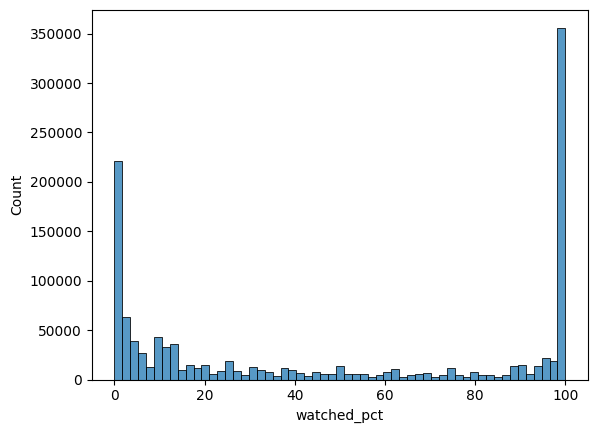

In [51]:
print(train_part.isnull().sum())
sns.histplot(train_part.watched_pct)

In [52]:
# Пропуски в просмотрах заполним просто 0

# train_part.watched_pct.fillna(0, inplace=True)
train_part.watched_pct.isna().sum()

265

Небольшая странность - у нас в взаимодействиях много пользователей (93к), которых нет в user_df

In [53]:
train_part.user_id.nunique() - users_df.user_id.nunique()

93011

In [54]:
items_df['month_watched'] = items_df['month_watched'].round().astype(int)
items_df['mans_percent'] = (100*items_df['mans_percent']).round().astype(int)
items_df['mean_watched_pct'] = (100*items_df['mean_watched_pct']).round().astype(int)
items_df['decade'] = items_df['decade'].round().astype(int)
users_df['mean_watched_pct'] = (100*users_df['mean_watched_pct']).round().astype(int)

In [55]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366088 entries, 0 to 366087
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   user_id           366088 non-null  int64   
 1   age               366088 non-null  category
 2   income            366088 non-null  category
 3   sex               366088 non-null  category
 4   kids_flg          366088 non-null  bool    
 5   age_sex           366088 non-null  category
 6   income_sex        366088 non-null  category
 7   age_income        366088 non-null  category
 8   nwatched          366088 non-null  int64   
 9   mean_watched_pct  366088 non-null  int64   
dtypes: bool(1), category(6), int64(3)
memory usage: 13.6 MB


## Теперь сохраним данные 

In [56]:
train_part.to_csv('kion_data/my_train.csv', index=False)
items_df.to_csv('kion_data/my_items_df.csv', index=False)
users_df.to_csv('kion_data/my_users_df.csv', index=False)

In [57]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12066 entries, 0 to 12065
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   item_id           12066 non-null  float64 
 1   content_type      12066 non-null  object  
 2   title             12066 non-null  object  
 3   title_orig        12066 non-null  object  
 4   release_year      12066 non-null  float64 
 5   genres            12066 non-null  object  
 6   countries         12066 non-null  object  
 7   for_kids          12066 non-null  float64 
 8   age_rating        12066 non-null  float64 
 9   studios           12066 non-null  category
 10  directors         12066 non-null  category
 11  actors            12066 non-null  category
 12  description       12066 non-null  object  
 13  keywords          12066 non-null  object  
 14  decade            12066 non-null  int64   
 15  nwatched          12066 non-null  int64   
 16  mean_watched_pct  1206

### Перейдем к моделям, начнем с супер простого подхода – давайте всем рекомендовать топ популярных (по числу просмотров) айтемов

# Baseline #1 – Топ Популярных

In [58]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
test_part.head()

,user_id,ground_truth,toppopular_recs
0,30,"[8584, 3031, 15363]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
1,144,"[3800, 11987, 10942]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
2,241,"[14841, 6162, 5808, 15266]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
3,259,"[16509, 10509, 4491, 5434, 4471, 10772, 817]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
4,475,"[6214, 3734, 6686]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."


##### Посмотрим на метрики, для этого передаем тестовый датафрейм и колонку с предсказаниями, в нашем случае это `toppopular_recs`  

In [59]:
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")


{'ndcg': 0.17037237918248196, 'recall': 0.0763696799665908}

#### Не пугайтесь таких маленьких значений, в RecSys задачах часто очень тяжело подстроиться под данные, поэтому абсолютные значения невелики. Чтобы по-настоящему оценить качество вашей модели, нужно сранвить ее с каким-то простым решением, которое можно считать отправной точкой. Наш бейзлайн с популярными фильмами как раз подходит!

# Baseline #1.1

### Дополним прошлый baseline - теперь не будем рекомендовать пользователям уже просмотренные фильмы

In [60]:
# Теперь мы будем убирать просмотренные фильмы из рекомендаций
class TopPopularUnwatched(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.user_actions = df
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        preds = []
        for user in tqdm(df.user_id):
            user_watched = self.user_actions[self.user_actions.user_id == user].item_id.unique()
            
            tmp = []
            for rec in self.recommendations:
                if rec not in user_watched:
                    tmp.append(rec)
                if len(tmp) == topn:
                    break
            
            preds.append(tmp)
        
        return preds
    
toppop_watched = TopPopularUnwatched()
toppop_watched.fit(train_part)
test_part["toppopular_watched_recs"] = toppop_watched.predict(test_part)
test_part.head()

evaluate_recommender(df=test_part, model_preds_col="toppopular_watched_recs")


  0%|          | 0/18693 [00:00<?, ?it/s]

{'ndcg': 0.1729488339534651, 'recall': 0.0777536066175902}

 # Ой, какие мы классные, побили прошлый бейслайн, можно выводить в прод!
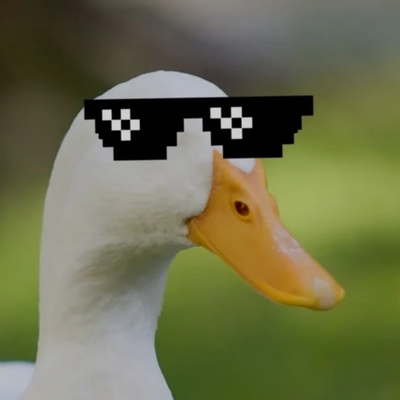

# Если серьезно - дальше я попытался побить бэйслайн используя ALS, но сильно лучше не стало. Потому можно переходить в следующий файл recs.ipnb

### Теперь возьмем подход посложнее, уже математически подкованный
Мы можем представить просмотры пользователей, как матрицу, где по столбцам будут отложены айтемы, а по строкам – пользователи. В `[i,j]` ячейке будет стоять 1, если пользователь смотрел фильм/сериал и 0, если нет.  
Тогда нашей задачей будет разложить исходную матрицу на две: матрицу пользователей и матрицу айтемов, перемножив которые, мы бы максимально приблизили известные нам единички. 
Такой подход позволит нам заполнить все пропуски в нашей матрице, то есть все нули. 

Для этого метода будем использовать модель **Alternating Least Squares (ALS)**. Она оптимизирует наши матрицы таким образом, чтобы мы хорошо восстанавливали все единички. 
Подробнее про модель можно почитать в [документации](https://benfred.github.io/implicit/), или, например, [тут](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe), или как всегда – в интернете.

![Alt text](./images/mf.png)


# Baseline #2 – Матричное разложение

In [61]:
class ALS(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs
    


In [62]:
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)


  0%|          | 0/1 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

#### Снова считаем метрики 

In [63]:
evaluate_recommender(test_part, model_preds_col="als_recs")


{'ndcg': 0.15702657768326359, 'recall': 0.06956445160783432}

### Ой-ой, кажется, что качество стало хуже, чем у популярных фильмов. Возможно мы плохо обучили модель, не самым правильным образом обработали данные, или она просто не подходит для этих данных, в любом случае, вам предстоит узнать можно ли обогнать `toppop` на данном датасете.

# Так что же нужно сделать?

### tl;dr – красивые визуализации, креативные подходы, различные модели

**Мы не ставим перед вами задачу выбить лучший скор на тестовой выборке** (хотя это очень желательно), задание скорее в том, чтобы исследовать различные подходы, поискать инсайты в данных, построить красивый анализ своих предсказаний и поиграться с данными.

Если говорить более формально, то мы будем оценивать следующее:
1. Какие методы вы попробовали для решения задачи
   ##### Это могут быть
   * статистически подходы, основанные на вашем анализе данных
   * классические метрические методы, вроде knn, а как посчитать вектора пользователей – пусть уже ваша фантазия вам диктует. Здесь вам помогут item-based модели, вроде EASE или SLIM
   * затюненный или модифицированный ALS (ну или любая другая модель матричной факторизации)
   * классические модели вроде градиентных бустингов (catboost, lightGBM) тоже работают в таких задачах (вам ведь ничего не мешает учить классификатор на просмотренный и непросмотренный фильмы, правда? осталось только насэмплить вторых)
   * очень приветствуются (но не обязательны) DL подходы, например [DSSM](https://kishorepv.github.io/DSSM/), [NCF](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401), [Bert4Rec](https://towardsdatascience.com/build-your-own-movie-recommender-system-using-bert4rec-92e4e34938c5) или [любой другой алгоритм](https://habr.com/ru/companies/prequel/articles/573880/), который вы найдете, например графовые или дифузионные подходы, почему нет)
     
   В общем нет никаких ограничений на модели, используйте то, что вам нравится или кажется логичным. Не стоит бросаться в крайности: обучать целый зоопарк моделей или затюнить одну до 0 ошибки. Найдите баланс между количеством и качеством)
2. Как хорошо вы валидировали свои модели
3. EDA (Exploration Data Analysis) данных, с которыми вы работаете
4. EDA полученных рекомендаций, насколько они разнообразные, насколько смещены в сторону популярных айтемов и всякое такое
5. **Обязательно** сохраните свою лучшую модель (файлик обученной модели), чтобы мы могли воспроизвести ваш результат!


## Помните:
1. Все дополнительные источники данных **обязательно** должны быть описаны
2. Нет правильного способа решить задачу. Не стоит беспокоиться, что вы делаете что-то неправильно. Мы хотим увидеть творческий подход и ваши способности к исследованию и прототипированию, а не какое-то конкретное решение задачи.
3. Вы можете использовать любые библиотеки и фреймворки, которые вам могут быть необходимы.
4. Сфокусируйтесь на том, чтобы код были чистый и понятный. Если вы считаете, что какая-то его часть может быть непонятна, то добавьте комментарии. Мы очень сильно ценим хорошо написанный код и выводы, поэтому если решение задачи будет оформлено грязно, то мы можем отклонить заявку.

## Результат
Мы ожидаем увидеть один или два (EDA + обучение моделей) ноутбук(а) на вашем [GitHub](https://github.com/) или ссылками на ваш [Google Colab](https://colab.research.google.com/?hl=ru).


In [64]:
class ALS(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(factors=10, 
                                regularization=0.05, 
                                iterations=10, 
                                random_state=10,
                                            )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs
    
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs_cusom"] = als_rec.predict(test_part)
evaluate_recommender(test_part, model_preds_col="als_recs_cusom")


  0%|          | 0/10 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

{'ndcg': 0.11459520457486976, 'recall': 0.047931364245496405}